In [32]:
from math import floor 

def discretize(waiting_times):
    
    return int(100000*abs(round(waiting_times[0], 1)) + 1000*abs(round(waiting_times[1], 1)) + 10*abs(round(waiting_times[2], 1)))

In [33]:
def append_packets(packet_info, queues, time):
    for i in range(len(packet_info)):
            for sublist in packet_info:
                if sublist[0] == i:
                    whole_packets = floor((time*sublist[1] - sublist[3]))
                    if whole_packets > 0:
                        queues[i].append(0)
                        print("Appending to queue", i)
                        sublist[3] += 1
                        
def calc_reward(curr_mean_delay_best_effort, current_waiting_time, queues, action):

#   reward for clearing list
    if not any(queues):
        return 25
#   heavily penalize for choosing empty queue
    if (len(queues[action]) == 0):
        return -25
#   penalize for not popping queue 1 when it has a mean delay over 4
    elif current_waiting_time[0] < -4 and action != 0:
        return -10
#   penalize for not popping queue 2 when it has a mean delay over 6
    elif current_waiting_time[1] < -6 and action != 1:
        return -10
    else:
        if curr_mean_delay_best_effort == 0:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       reward if model improves mean_delay in best effort
        elif curr_mean_delay_best_effort < current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       penalize slightly if model mean_delay in best effort queue increases
        elif curr_mean_delay_best_effort > current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            reward = -1
        else:
            reward = 1

def add_time(queue):
    for i in range(len(queue)):
        queue[i] -= 1
    
        
def calc_mean_delay(queue):
    # Calculate the length and average waiting time of the current queue
    current_length = len(queue)
    current_waiting_time = np.average(queue) if current_length > 0 else 0.0
    #print(np.average(current_queue), current_length, current_waiting_time )
    current_waiting_time = np.round(current_waiting_time, 1)
    return current_waiting_time

def catch_over_ten_second_mean_delay(waiting_time):
    if waiting_time < -9.9:
        waiting_time = -9.9

def generate_random_numbers():
    random_sum = random.uniform(0.8, 1.0)  # Generate a random sum between 0.8 and 1.0
    random_numbers = []

    for _ in range(2):
        random_value = round(random.uniform(0.0, random_sum), 2)  # Generate a random value between 0.0 and the remaining sum with a maximum of one decimal place
        random_numbers.append(random_value)
        random_sum -= random_value

    random_numbers.append(round(random_sum, 1))  # Append the remaining sum to the list with a maximum of one decimal place

    return random_numbers

In [34]:
import gym
from gym import spaces
import numpy as np
from math import ceil

class TrafficGenerator(gym.Env):
    
    def __init__(self, q1rate, q2rate, q3rate):
        
        self.action_space = spaces.Discrete(3)
        
        # Define the observation space (number of packets in each queue and their waiting time)
        # Queue maximum length set to 100
        self.observation_space = spaces.Discrete(10000000)
        
        # pancket info (DataType, arrival_rate, mean_delay )
        #self.packetInfo = [[0, 0.3, 6],[1, 0.25, 4],[2, 0.4, float('inf')]]
        self.dataType = [0, 1, 2]
        self.arrival_rate = [q1rate, q2rate, q3rate]
        self.mean_delay_req = [6, 4, float('inf')]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.curr_mean_delay_best_effort = 0
        self.packet = 1
        self.timeslot = 1
        self.totaltime = self.timeslot
        
        # Initialize the queues
        self.queues = [[], [], []]
      
    
    def step(self, action):  
        self.totaltime += self.timeslot
        #print(self.totaltime)
        #print("~~~~~~~~~~~~~~~")
        #print("Action Chosen: ", action)
       
       # if action < 3 and len(self.queues[action]) > 0:
        #    self.queues[action].pop(0)

        
        #OBSERVING ENVRONEMNT
        observation = []
        
        #append_packets(self.packetInfo, self.queues, self.totaltime)
        
        for i in range(len(self.mean_delay_req)):
            #add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue
            current_waiting_time = calc_mean_delay(current_queue)
            observation.append(current_waiting_time)
            
        reward = calc_reward(self.curr_mean_delay_best_effort, observation, self.queues, action)
        
        
        
        
        #UPDATING ENVIRONMENT
        if action < 3 and len(self.queues[action]) > 0:
            self.queues[action].pop(0)
    
        append_packets(self.packetInfo, self.queues, self.totaltime)
        
        observationUpdate = []        
        for i in range(len(self.mean_delay_req)):
            add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue\
            current_waiting_time = calc_mean_delay(current_queue)
            observationUpdate.append(current_waiting_time)       
            
        
        info = {"Mean Delay Req 0": self.mean_delay_req[0],
        "Mean Delay Req 1": self.mean_delay_req[1],
        "Mean Delay Req 2": self.mean_delay_req[2],
        "arrival_rate_0": self.arrival_rate[0],
        "arrival_rate_1": self.arrival_rate[1],
        "arrival_rate_2": self.arrival_rate[2]}
        #done = len(self.queues[0]) + len(self.queues[1]) + len(self.queues[2]) == 0
        done = (self.totaltime >= 100)
        print(observation)
        for i in range(3):
            catch_over_ten_second_mean_delay(observation[i])
        #print(f"WAITING TIMES {np.array(waiting_times)}")
        waiting_times = discretize(observationUpdate)
        
        
        
        return waiting_times, reward, done, info
        
    def reset(self):
        # Reset the queues
        self.queues = [[], [], []]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.totaltime = 1
        return [0,0,0]
    
    def change_arrival_rates(self,q1,q2,q3):
        self.arrival_rate = [q1,q2,q3]
        
    def render(self):
        pass

In [35]:
env = TrafficGenerator(0.3,0.25,0.4)
print('State space: ', env.observation_space)
print('Action space: ', env.action_space)


State space:  Discrete(10000000)
Action space:  Discrete(3)


env = TrafficGenerator()
obs = env.reset()
done = False
x = 0
while x < 100:
    print("~~~~~~~~~")
    action = env.action_space.sample()
    
    print("chosen", action)
    obs, reward, done, info = env.step(action)
    print(info)
    print(obs)
    print("reward", reward)
    
    x = x + 1

In [36]:
import random 

action_size = env.action_space.n
state_size = env.observation_space.n
qtable = np.zeros((state_size, action_size))
rewardstest = []
# Hyperparameters

total_episodes = 400
total_test_episodes = 50
max_steps = 999
learning_rate = 0.7
gamma = 0.618
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01

# Train
for episode in range(total_episodes):
    arr_rates = generate_random_numbers()
    env.change_arrival_rates(arr_rates[0], arr_rates[1], arr_rates[2])
    state = env.reset()
    total_rewards = 0
    print("Episode ", episode,"/", total_episodes )
    for step in range(max_steps):
        exp_exp_tradeoff = random.uniform(0, 1)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state, :])
        else:
            action = env.action_space.sample()
        
        new_state, reward, done, info = env.step(action)
        total_rewards += reward
        #print(new_state)
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])
        state = new_state
        print(reward)
        if done: 
            rewardstest.append(total_rewards)
            break

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * (episode+1))




Episode  0 / 400
Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 0
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, 0.0]
-25
Appending to queue 0
Appending to queue 2
[-2.0, 0.0, 0.0]
-25
Appending to queue 0
[-2.0, 0.0, -1.0]
1
Appending to queue 0
[-1.5, 0.0, -2.0]
1
[-1.5, 0.0, -3.0]
1
Appending to queue 0
[-2.0, 0.0, -4.0]
1
Appending to queue 0
Appending to queue 2
[-1.0, 0.0, -5.0]
1
Appending to queue 0
[-1.5, 0.0, -1.0]
1
[-2.0, 0.0, 0.0]
-25
Appending to queue 0
[-3.0, 0.0, 0.0]
-25
Appending to queue 0
[-3.2, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[-3.0, 0.0, 0.0]
1
[-2.8, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 1
[-3.8, 0.0, 0.0]
-25
Appending to queue 0
[-4.0, -1.0, 0.0]
1
Appending to queue 0
[-3.6, -2.0, 0.0]
1
Appending to queue 2
[-4.0, 0.0, 0.0]
1
Appending to queue 0
[-4.4, 0.0, -1.0]
-25
Appending to queue 0
[-4.7, 0.0, -2.0]
-25
Appending to queue 0
[-5.0, 0.0, -3.0]
-25
[-5.4, 0.0, -4.0]
-25
Appending to queue 0
Appending to queue 2
[-6.4, 0.0,

25
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
-25
Appending to queue 0
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-1.5, 0.0, 0.0]
1
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
-25
Appending to queue 0
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-1.5, 0.0, 0.0]
-25
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-2.5, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 

Appending to queue 2
[0.0, 0.0, 0.0]
25
[0.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 0
Appending to queue 2
[0.0, 0.0, -1.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 2
[-2.0, 0.0, 0.0]
-25
[-3.0, 0.0, -1.0]
1
Appending to queue 2
[-4.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, -1.0]
1
[-1.0, 0.0, -1.0]
-25
Appending to queue 2
[-2.0, 0.0, -2.0]
1
Appending to queue 1
[-3.0, 0.0, -1.0]
1
Appending to queue 2
[-4.0, -1.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[0.0, -2.0, -1.0]
1
[-1.0, -3.0, -1.0]
1
Appending to queue 2
[-2.0, 0.0, -2.0]
1
[-3.0, 0.0, -1.0]
1
Appending to queue 2
[0.0, 0.0, -2.0]
-25
Appending to queue 0
Appending to queue 2
[0.0, 0.0, -2.0]
1
[-1.0, 0.0, -1.5]
1
Appending to queue 2
[0.0, 0.0, -2.5]
1
[0.0, 0.0, -2.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, -2.0]
1
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, -1.0]
1
[-2.0, -1.0, -1.0]
1
Appending to queue 2
[0.0, -2.0, -2.0]
1
[

Appending to queue 1
[0.0, 0.0, 0.0]
25
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, 0.0]
25
Appending to queue 2
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, -1.0]
1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, 0.0]
25
[0.0, -1.0, 0.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 1
[-1.0, -1.0, -1.0]
1
[0.0, -1.5, -2.0]
1
Appending to queue 1
[0.0, -2.0, -3.0]
1
[0.0, -2.0, 0.0]
1
Appending to queue 1
Appending to queue 2
[0.0, -2.0, 0.0]
1
[0.0, -1.0, -1.0]
1
Appending to queue 1
[0.0, 0.0, -2.0]
1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, 0.0]
25
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, -1.0, 0.0]
1
[-1.0, -1.0, -1.0]
1
Appending to queue 1
[0.0, -2.0, -2.0]
1
[0.0, -1.0, -3.0]
1
Appending to queue 1
[0.0, -2.0, 0.0]
1
Appending to queue 2
[0.0, -1.0, 0.0]
-25
Appending to queue 1
[0.0, -2.0, -1.0]
1
[0.0, -2.0, 0.0]
-25
Appending to queue 1
[0.0, -3.0, 0.0]
1
[0.0, -2.0,

Appending to queue 0
[-2.5, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 2
[-1.5, 0.0, 0.0]
-25
Appending to queue 0
[-2.5, 0.0, -1.0]
1
Appending to queue 0
[-2.0, 0.0, -2.0]
1
[-1.5, 0.0, -3.0]
1
Appending to queue 0
[-2.0, 0.0, -4.0]
1
Appending to queue 0
Appending to queue 2
[-2.0, 0.0, 0.0]
1
[-1.5, 0.0, -1.0]
1
Appending to queue 0
[-2.0, 0.0, -2.0]
1
[-1.0, 0.0, -3.0]
1
Appending to queue 0
Appending to queue 1
[0.0, 0.0, -4.0]
1
Appending to queue 0
Appending to queue 2
[-1.0, -1.0, 0.0]
1
[-1.0, -2.0, -1.0]
1
Appending to queue 0
[0.0, -3.0, -2.0]
1
Appending to queue 0
[-1.0, -4.0, 0.0]
1
[-1.0, -5.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[0.0, -6.0, 0.0]
-25
Appending to queue 0
[-1.0, -7.0, -1.0]
-10
[-1.0, -8.0, -2.0]
-10
Appending to queue 0
[-2.0, -9.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 2
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, -1.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
[-1.5, 0.0, 0.0

Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, -1.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 0
[0.0, 0.0, -2.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[-1.0, 0.0, 0.0]
1
[-1.0, -1.0, 0.0]
1
Appending to queue 0
[0.0, -2.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, 0.0]
-25
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, -1.0, -1.0]
1
[-1.5, -2.0, 0.0]
-25
Appending to queue 0
[-2.5, -3.0, 0.0]
1
Appending to queue 0
[-2.7, 0.0, 0.0]
1
[-2.3, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[-2.5, 0.0, 0.0]
1
Appending to queue 0
[-2.0, -1.0, 0.0]
1
[-2.3, 0.0, 0.0]
1
Appending to queue 0
[-2.5, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[-2.0, 0

[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, -1.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[-1.0, 0.0, 0.0]
1
Episode  236 / 400
Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 0
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 0
[-1.0, 0.0, 0.0]
-25
Appending to queue 0
[-1.5, 0.0, 0.0]
1
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, -1.0, 0.0]
1
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1


[0.0, 0.0, 0.0]
25
[0.0, 0.0, 0.0]
25
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
[-1.0, -1.0, -1.0]
1
[0.0, -2.0, -2.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, -3.0]
1
Appending to queue 1
[-1.0, 0.0, -1.0]
1
[0.0, -1.0, -2.0]
1
Appending to queue 0
Appending to queue 2
[0.0, -2.0, 0.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 1
[0.0, 0.0, -2.0]
1
Appending to queue 0
[0.0, -1.0, 0.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, -1.0]
1
Appending to queue 0
[0.0, -1.0, 0.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
25
Appending to queue 2
[-1.0, -1.0, 0.0]
1
[0.0, -2.0, -1.0]
1
Appending to queue 0
[0.0, 0.0, -2.0]
1
Appending to queue 1
[-1.0, 0.0, 0.0]
1
Appending to queue 2
[0.0, -1.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, -1.0]
1
Appending to queue 1
[-1.0, 0.0, 0.0]
1
Appending to queue 2
[0.0, -1.0, 0.0]
1
Appending to qu

Appending to queue 1
[-2.0, -2.0, 0.0]
1
Appending to queue 0
[-2.0, -2.0, 0.0]
-25
[-2.0, -3.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[-3.0, -3.0, 0.0]
1
[-3.0, -1.0, 0.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-4.0, 0.0, 0.0]
1
[-3.0, -1.0, -1.0]
1
Appending to queue 0
[-4.0, 0.0, -2.0]
1
Appending to queue 1
[-3.0, 0.0, -3.0]
1
Appending to queue 0
[-4.0, -1.0, 0.0]
1
Appending to queue 1
[-3.0, -2.0, 0.0]
1
Appending to queue 0
[-3.0, -2.0, 0.0]
1
[-3.0, -2.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[-3.0, -3.0, 0.0]
1
[-3.0, -1.0, 0.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[-4.0, 0.0, 0.0]
1
Episode  267 / 400
[0.0, 0.0, 0.0]
25
Appending to queue 1
[0.0, 0.0, 0.0]
25
Appending to queue 0
[0.0, -1.0, 0.0]
1
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
[0.0, -1.0, -1.0]
1
[0.0, -2.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
25
[-1.0, -1.0, 0.0]
1
Appending to queue 1
Ap

Appending to queue 1
[-1.0, -2.0, 0.0]
1
Appending to queue 1
Appending to queue 2
[0.0, -2.0, 0.0]
1
[0.0, -1.5, -1.0]
1
Appending to queue 0
Appending to queue 1
[0.0, -2.0, -2.0]
1
[-1.0, -1.0, -3.0]
1
Appending to queue 1
[-2.0, -2.0, 0.0]
1
Appending to queue 0
[0.0, -2.0, 0.0]
1
Appending to queue 1
[-1.0, -2.0, 0.0]
1
Appending to queue 1
[0.0, -2.0, 0.0]
1
Appending to queue 0
[0.0, -1.5, 0.0]
1
Appending to queue 1
[-1.0, -2.0, 0.0]
1
Appending to queue 2
[0.0, -2.0, 0.0]
1
Appending to queue 1
[0.0, -2.0, -1.0]
1
Appending to queue 0
[0.0, -2.0, 0.0]
1
Appending to queue 1
[-1.0, -2.0, 0.0]
1
Appending to queue 1
[0.0, -2.0, 0.0]
1
Appending to queue 0
[0.0, -1.5, 0.0]
1
Appending to queue 1
[-1.0, -2.0, 0.0]
1
[0.0, -2.0, 0.0]
1
Appending to queue 1
[0.0, -2.0, 0.0]
1
Appending to queue 0
[0.0, -1.0, 0.0]
1
Appending to queue 1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, -1.0]
1
Appending to queue 0
[0.0, -1.0, -2.0]
1
Appending to queue 1
[-1.0,

[-1.0, 0.0, -1.0]
1
Appending to queue 2
[-2.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[0.0, 0.0, -1.0]
1
Appending to queue 2
[-1.0, -1.0, 0.0]
1
[0.0, -2.0, -1.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, -2.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 2
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, -1.0]
1
Appending to queue 2
[-1.0, 0.0, 0.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Episode  300 / 400
Appending to queue 2
[0.0, 0.0, 0.0]
25
[0.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, 0.0]
25
[-1.0, 0.0, -1.0]
1
Appending to queue 2
[-2.0, 0.0, 0.0]
1
[0.0, 0.0, -1.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
[-1.0, -1.0, -1.0]
1
Appending to queue 2
[0.0, -2.0, -2.0]
1
[0.0, 0.0, -2.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, -2.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 2
[-2.0, 0.0, 0.0]
1
Appending to q

Appending to queue 0
[0.0, 0.0, 0.0]
25
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 0
Appending to queue 2
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 0
[-1.0, 0.0, -1.0]
1
[-1.0, 0.0, -2.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 1
Appending to queue 2
[0.0, 0.0, 0.0]
25
Appending to queue 0
[-1.0, -1.0, -1.0]
1
[-1.0, -2.0, -2.0]
1
Appending to queue 0
[-2.0, -3.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 2
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, -1.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 2
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, -1.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
[-1.0, 0.0, 0

Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
-25
Appending to queue 0
[-1.5, 0.0, 0.0]
1
[-1.5, 0.0, 0.0]
1
Appending to queue 0
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[-1.0, 0.0, 0.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, 0.0]
25


Appending to queue 1
[-1.0, 0.0, 0.0]
1
[0.0, -1.0, 0.0]
1
Appending to queue 0
[0.0, 0.0, 0.0]
25
Appending to queue 1
[-1.0, 0.0, 0.0]
1
[0.0, -1.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
25
[-1.0, -1.0, 0.0]
-25
Appending to queue 1
[-2.0, -2.0, 0.0]
1
Appending to queue 0
[0.0, -2.0, 0.0]
1
[-1.0, -2.0, 0.0]
1
Appending to queue 1
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, -1.0, 0.0]
1
Appending to queue 1
[-1.0, 0.0, 0.0]
1
[0.0, -1.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
25
[-1.0, -1.0, 0.0]
1
[-2.0, 0.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[0.0, 0.0, 0.0]
25
[-1.0, -1.0, 0.0]
1
Appending to queue 1
[-2.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, -1.0, 0.0]
1
Appending to queue 1
[-1.0, 0.0, 0.0]
1
Appending to queue 0
[0.0, -1.0, 0.0]
1
[-1.0, 0.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, 0.0]
25
Appending to queue 0
[0.0, -1.0, 0.0]
1
Appending to queue 1
[-1.0, 0.0, 0.0]
1
[0.0, -1.0, 0.0]
1
Appending to queue 0

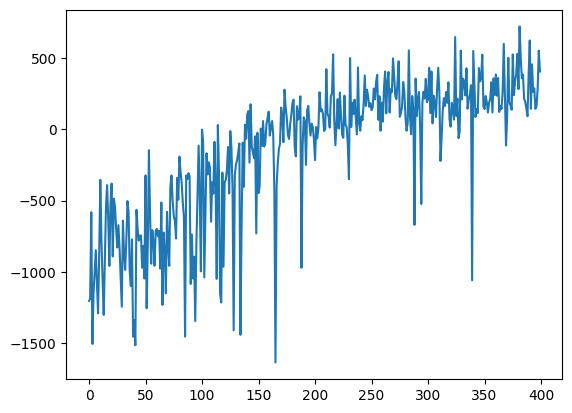

In [37]:
import matplotlib.pyplot as plt
import numpy as np
 #Plot the data\n
plt.plot(rewardstest)
# Show the plot\n",
plt.show()

In [38]:
print(rewardstest)

[-1204, -1188, -581, -1506, -1151, -998, -847, -1084, -1291, -870, -354, -780, -1055, -1302, -909, -543, -391, -625, -958, -527, -380, -891, -486, -545, -697, -829, -672, -829, -1033, -1245, -640, -869, -986, -784, -503, -580, -993, -1099, -772, -1456, -1338, -1515, -564, -696, -780, -746, -744, -971, -817, -1047, -323, -1255, -813, -146, -584, -943, -707, -784, -957, -711, -698, -750, -711, -977, -513, -1232, -724, -855, -1151, -579, -813, -958, -401, -323, -501, -608, -641, -766, -340, -493, -191, -297, -376, -517, -617, -1454, -323, -349, -307, -328, -1085, -737, -1046, -893, -1345, -811, -450, -113, -475, -996, -1, -87, -1039, -598, -167, -316, -231, -267, -647, -370, -451, -87, -378, -1049, 31, -299, -1154, -1214, -303, -964, -373, -353, -284, -123, -449, -11, -123, -421, -1410, -323, -245, -217, -163, -99, -1442, -679, -93, -403, 33, -65, 105, 129, -233, 177, -119, -160, -202, -48, -730, -23, -447, -401, 6, -116, 59, -120, -93, 35, 83, 125, -43, 15, 59, -35, -428, -1636, -394, -2

In [46]:
# Play the Game
rewards = []
arr = generate_random_numbers()
env = TrafficGenerator(arr[0],arr[1],arr[2])

for episode in range(total_test_episodes):
    total_rewards = 0
    total_penalties = 0
    
    state = env.reset()
    print('='*40)
    print("[*] Episode", episode)
    print('='*40)

    for step in range(max_steps):
        env.render()
        action = np.argmax(qtable[state, :])
        state, reward, done, info = env.step(action)
        print(reward)
        """"
        if reward == -10:
            total_penalties += 1
        else:
            total_rewards += reward
        """
        total_rewards += reward
        #print("total time: {}", env.totaltime)
        if done:
            rewards.append(total_rewards)
            print('[*] Score', total_rewards)
            break

env.close()
print('[*] Average Score: ' + str(sum(rewards) / total_test_episodes))

[*] Episode 0
Appending to queue 1
[0.0, 0.0, 0.0]
25
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, 0.0]
25
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, 0.0]
25
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[-1.0, -1.0, 0.0]
1
[-2.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -2.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, 0.0]
25
Appendi

Appending to queue 1
[0.0, 0.0, 0.0]
25
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, 0.0]
25
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, 0.0]
25
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 0
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[-1.0, -1.0, 0.0]
1
[-2.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -2.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, -1.0, 0.0]
1
[0.0, -1.0, 0.0]
1
Appending to queue 1
[0.0, 0.0, 0.0]
25
Appending to queue 1
